RNN으로 여행자 수 예측, 2022년 1월 8일 김이룸

In [ ]:
# 1번 셀

# 패키지 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler # 정규화방법 두개
from keras.layers import Dense, LSTM, InputLayer, SimpleRNN # Dense : 완전 연결층, simpleRNN : LSTM cell 대신 사용
from keras.models import Sequential # 층을 추가해서 인공신경망을 만드는 방법론
from sklearn.model_selection import train_test_split

In [ ]:
# 2번 셀

# 파라미더

# my past : 몇개년도를 보고 여행자 수를 예측할 것이냐
MY_PAST = 3 # 12 # 미래 예측을 위해 사용하는 과거의 데이터 수, 입력 데이터 수 -> 12달 치 입력 받아서 13번째 달의 여행자 수를 예측하는 것이다., 과거를 '몇개'로, 미래를 1개로
# 위 값이 크면 안좋다. 몇십년전부터의 데이터를 보지 않는다. 최근동향을 본다. 주식은 수치만 보면 안된다.
MY_SPLIT = 0.8 # 학습용 데이터 비율
MY_HIDDEN = 300 # RNN 셀 내부 복잡도 혹은 다음 단으로 넘겨주는 데이터 차원의 수
# 맥아피 사용한다.
MY_SHAPE = (MY_PAST, 1) # RNN 입력 데이터 모양
MY_EPOCH = 300 # 반복 학습 수


     1
0  112
1  118
2  132
3  129
4  121
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


(144, 1)

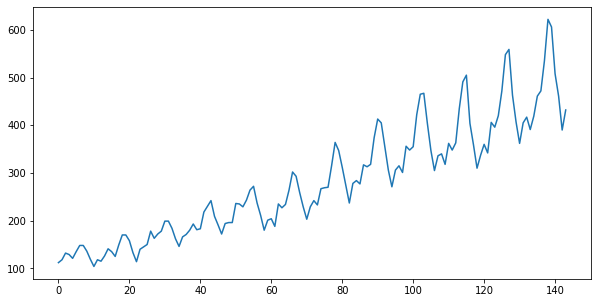

In [ ]:
# 3번 셀

# 데이터 읽기
path = '/content/drive/MyDrive/my-data/airline.csv'
# 헤더가 없으면 없다고 말해야돼
# pd.read_csv() : csv 파일을 pd.DataFrame()으로 불러온다.
# usecols : 해당 column만 사용하겠다. <- column 0는 date라서
data = pd.read_csv(path,
                   header=None,
                   usecols=[1])

# 샘플 출력 - 112는 11만2천 , 단위가 천 
print(data.head())

# 통계출력 - 이미지처리에서는 필요없음 .
print(data.describe()) # min 104는 백사가 아니라 십만사천

# 그래프 그리기
plt.figure(figsize=(10,5))
plt.plot(data) # 업앤다운이 있다- 성수기, 비수기
data.shape

정규화 전 :  [112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 413 405 355 306 271 306 315 301 356 348 355 422 465 467 404 347 305 336
 340 318 362 348 363 435 491 505 404 359 310 337 360 342 406 396 420 472
 548 559 463 407 362 405 417 391 419 461 472 535 622 606 508 461 390 432]
정규화 후 :  [0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.1196

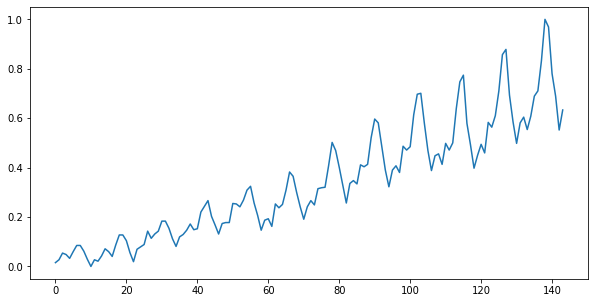

In [ ]:
# 4번 셀

# 데이터 정규화
# scale = StandardScaler() # 표준정규분포를 만드는 z-정규화 -> 이번에는 사용안함
# data : type -> pandas
# m_data = numpy
# scikitlearn에서 numpy에서 전환해서 넘겨줬어. 내가 한거 아니야. 여기서 처신을 잘해야한다. 넘파이를 판다스로 넘겨야한다.
# MinMaxScaler() : Scaling한 data를 numpy.ndarray로 넘겨준다., [0,1] 사이로 스케일링.
scaler = MinMaxScaler()
m_data = scaler.fit_transform(data) # MinMax니깐 m data # MinMax 정규화, 데이터가 망가지지 않음을 plot로 확인할 수 있다.
# print('정규화 전 : ',data.flatten()) # dataFrame은 플래튼이 없다.
print('정규화 전 : ',data.to_numpy().flatten()) # 
print('정규화 후 : ',m_data.flatten()) # CNN 안에 있던 flatten()이랑 이름만 똑같은거다. 한줄에 여러개 나오게 해준다.
# numpy를 pandas로 재전환
# m_data = pd.DataFrame(m_data)

# 민맥스와 z정규화 둘의 차이점은 무엇인가? 답 : 판서 비교를 참고하시오.
# 스케일링의 원리와 집합론 원투원 코레스펀던스 이론.
# print(m_data.describe()) # min=0, max=1

# mean과 std가 0과 1이 아니므로 민맥스스케일러는 z점수 정규화가 아니다. 반환값이 표준정규분포를 따르지 않는다.
plt.figure(figsize=(10,5))
plt.plot(m_data) # 모양은 data plot과 다를게 없다. 하지만 y-axis 스케일이 변했다.축소되었다.

In [ ]:
# 5번 셀

# 데이터 분할
split =[] # list
size = len(m_data)
print('데이터 수 : ', size) # 144개

# 데이터 분할 1 : 시계열 데이터 분할
# 전체 데이터 수 - MY_PAST : 묶음(가래떡) 수  : 144 -3 : 141
# 144개가 아니라 데이터가 12개 있다고 가정하고 시계열 데이터 분할 묶음 슬라이드를 참고하시오
# 옵션1이 최선인가? 이보다 더 좋은 분할 방법은 없을까? 옵션1은 데이터가 너무 낭비되는거다. 바보나 사용하는 방법이 옵션 1이다.
# 옵션2 : '한단씩 미루고 묶기' -> 데이터 12개를 쥐어짜고 짜서 아주 알뜰하게 쓴 것. 가장 확실하게 데이터를 쓰는 방법
# 데이터 수 - 묶음길이 + 1
# 강의자료 - 시계열데이터 분할 묶음 -> MY_PAST =3 
# size - MY_PAST :
# i부터 i+3
#  i + MY_PAST + 1 : 1 더하는 이유 -> 슬라이싱 마지막 아이템 포함안해서.
# 데이터가 몇개 안될 때, 최대한 닦아쓰는 방법 : 옵션  2 <------- 시계열 데이터 처리방법 - 무조건 알아야하는 컨셉 in RNN
for i in range(size - MY_PAST):
  split.append(m_data[i: i + MY_PAST + 1])


print(m_data.flatten()) # 144개 다 떳다. 
print(split[0]) #첫번째 네개짜리 찍음
print(split[1]) # 실행 전에
print('총 4개 묶음 수 : ',len(split))

# btc : bit coin
# 비트코인 데이터 : 야후에서 다운로드 -> 비트코인이 처음 팔린 날부터의 가격을 
# 야우 파이낸스 비트코인의 평생 데이터 : 2671개 밖에 안된다. 보통 시계열데이터는 개수가 많지 않다. 그래서 우리는 열심히 닦아써야한다.

# 9 = 12 -3
# 141 = 144  - 4 + 1 

# 0.01544402 0.02702703 0.05405405 0.0482625 : 가래떡 1
# [[0.01544402]
#[0.02702703]
# [0.05405405]
#[0.04826255]]
# 같은 수가 나온다.

# 0.01544402 0.02702703 0.05405405 0.04826255

데이터 수 :  144
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734
 0.34749035 0.33397683 0.41119691 0.4034749  0.41

In [ ]:
# 6번 셀 

# 분할 데이터 추가 처리
print(type(split))
# 리스트 넘파이로 전환하기
split = np.array(split)
print(type(split))
print('시계열 분할 데이터 모양 : ',split.shape)

# 144 데이터 개수
# 4 : 4개씩 잘랐다.
# 3차원 데이터 해석 : 판서와 같이 각각이 1차원을 이룬다.
# 데이터 차원을 확일할 때 첫 대괄호가 몇개인지 카운트하면 된다.

# print(split) : 각 묶음 첫 3개는 입력데이터 마지막 1개는 출력데이터

<class 'list'>
<class 'numpy.ndarray'>
시계열 분할 데이터 모양 :  (141, 4, 1)


In [ ]:
# 7번 셀 

# 데이터 분리 - 0번 가래떡만 짜를게 아니다.141개 다 잘라야 돼.
X_data = split[0:142, 0:MY_PAST] # 가래떡 141개 묶음 - 0, 1, 2
# X_data = split[:, 0:MY_PAST]
# X_data
print('입력 데이터 모양 : ',X_data.shape) # 141,4,1에서 141,3,1이 되었다.

# Y_data = split[:,MY_PAST] # MY_PAST = 3 -> 이보다 아래 답이 더 수준 높은 코드다.
Y_data = split[:, -1] # 마지막 인덱스
#print(split[0])
#print(X_data[0])
#print(Y_data[0]) 

print('출력 데이터 모양 :',Y_data.shape) # 2차원데이터

# 6번,7번 셀은 다음주 다시 설명함.
# 오늘은 즐기고 이번 기회를 놓치지 않겠다 싶으면 
# 완벽하게 소화하고 싶은 사람이 있으면

# 우리 애저 6개, 코랩 2개있잖아, 이거를 코드를 외우는거야.
# 내 코드 보지말고 여러분이 백지상태에서 쭉 쫘는거야
# 아무것도 보지말고
# 머리로 생각하는 것과 똑같이 코딩할 수 있는지 여러분이 해봐라
#외워라
#혼자해봐라
#답이나오나
# 첫단계는 코딩 한줄 한줄 내가 이해할 수 있는지부터 시작할것

# 외우면 얻어가는 수준이 다를거야
# 사실 제가 그렇게 공부를 해

# 외워
# 할 수 있잖아? 그럼 완벽한거다
# 마스터하겠다고 결심하신분만해봐

입력 데이터 모양 :  (141, 3, 1)
출력 데이터 모양 : (141, 1)


In [ ]:
# limsk@gatech.edu -> 질문이나 커맨트

2022년 1월 10일 김이룸

In [ ]:
# 8번 셀

# 데이터를 학습용과 평가용으로 분할
# shuffle : True or False 결정을 잘해야한다. -> 시계열 데이터는 함부로 섞으면 안된다. 망한다.  -> 기본값은 True이다.
# 시계열 데이터는 절대로 섞지 않는다. -> shuffle=False
# 시계열 데이터는 결코 섞어서 사용하지 않는다 !
X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                    Y_data,
                                                    train_size=MY_SPLIT,
                                                    shuffle=False)

# 최종 데이터 모양 확인 : 144개 시계열 1차원 데이터를 아래와 같이 바꿨다.
# 시계열 데이터는 순서를 유지해야한다. 
print('학습용 입력 데이터 모양 : ',X_train.shape)
print('학습용 출력 데이터 모양 : ',Y_train.shape)
print('평가용 입력 데이터 모양 : ',X_test.shape)
print('평가용 출력 데이터 모양 : ',Y_test.shape)

학습용 입력 데이터 모양 :  (112, 3, 1)
학습용 출력 데이터 모양 :  (112, 1)
평가용 입력 데이터 모양 :  (29, 3, 1)
평가용 출력 데이터 모양 :  (29, 1)


In [ ]:
# 9번 셀

# RNN 구현  
# 구현 전에 설계도를 확인하라.
# 동일 구조가 반복이 되는 것 : LSTM cell
# 풀어해쳐지다 : RNN 풀어헤침 
# 마스터 구조(순환구조)를 세번 풀어해치면 오른쪽 세개와 같이 된다.
# 데이터가 밑에서 들어오고 왼쪽에서 오른쪽으로 흐른다
# 이번 모델은 RNN 종류 중 many-to-one 구조이다.
# 언폴딩의 수는 입력의 수와 같다. 
# [12,1]이 아니라 [3,1]이다. 12번째 달 여행자 수를 3번째달 여행자 수로 고쳐야한다. 입력: 3달치 여행자 수 (과거), 
# 파란색 제일 밑 박스처럼 시계열 데이터는 순서대로 들어가야한다.
# LSTM cell : RNN cell, 중요하다. -> Day 판서를 참고하라.
# 설계도 300 : MY_HIDDEN 값이다. 튜닝할 수 있다. 반응을 근거로 튜닝한다. 
# 파라미터 튜닝의 임팩 체크포인트 : 1) 정확도; 2) 학습시간

# k개가 들어온다. 
# 입력n 바로 위 뉴런이 다른 뉴런들보다 가치가 높은 정보를 다고 있다. 모든 입력을 다 사용. 왼쪽에서 전달을 해주니까.
# 가장 오른쪽 LSTM cell 의 300개 출력을 1개로 줄여야한다. -> 이를 위해 Dense에 연결한다.
# 300개 입력 받는 인풋레이어.
# 여행자 수 예측하는데 왜 여행자 수를 [0,1] 확률로 예측하는가? 답 : '데이터가 모두 [0,1] 안에 있기 때문이다. MinMax 스케일링을했기 때문이다. 예측하는 수도 [0,1] 사이 값이여야한다.(핵심)
# 여행자 수 예측하는데 왜 sigmoid 활성화함수를 사용하는? 답 : MinMax 스케일링을했기 때문에 데이터가 모두 [0,1] 안에 있다. 예측하는 수도 [0,1] 사이 값이여야한다.(핵심)4
# #  sigmoid : [-inf, inf] -> [0,1]
# 가중치는 음수일 수도 있다. [0,1] 제한이 없다.
# sigmoid 활성화란? 판서를 참고하시오.
# sigmoid : 주어진 입력 데이터러를 [0,1] 사이의 숫자로 전환
# 입력값이 -3.1로 들어왔을 때 출력값이 0과 1사이에 있는가? 답 : 네. 
# 입력값이 5.3 들어왔을 때 출력값이 0과 1사이인가? 답 : 네
# 입력값이 -inf 면 출력값이 0이다.
# 입력값이 +inf 면 출력값이 1이다.
#  sigmoid : [-inf, inf] -> [0,1] : two class logistic regression 에서 배웠다,
# 가장 중요한 정보를 모두 감고 있다.

# RNN 구현
model = Sequential()

# 입력층 - 하나짜리가 12개 들어간다.
# input_shape : 입력데이터 하나의 모양 : MY_SAHPE
model.add(InputLayer(input_shape=MY_SHAPE))

# RNN 셀 추가  : 마스터를 언폴딩
# units : 다음단으로 넘기는 숫자 개수
# LSTM cell은 고급기술이다.
# 처음만든분이 만든 모델이 simpleRNN이다. 80년도 기술.
model.add(SimpleRNN(units=MY_HIDDEN)) # 90600 -> MY_HIDDEN 튜닝가능하다.
# model.add(LSTM(units=MY_HIDDEN)) # 90600 -> 362400 : 파라미터가 4배 늘어났다.

# 출력층 : 맨 오른쪽 LSTM cell
# units : 출력층 뉴런개수
model.add(Dense(units=1,
                activation='sigmoid'))

# RNN 요약
# simpleRNN add 하기 전까지는 파다메터는 보이지 않는다.
# 90600개 : 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 300)               90600     
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 90,901
Trainable params: 90,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 10번 셀

# RNN 학습

# 학습 환경 설정
model.compile(optimizer='adam',
              loss='mae')

# RNN 학습 진행
# 반복학습 때마다 출력해주는 것을 끄는 방버
# 반복학습 진행도를 끄는 방법은 ? 답 : verbose = 0; verbose=1 : 키기 -> 끄면 학습시간 단축된다
print('학습시작')
begin = time()

model.fit(X_train,
          Y_train,
          epochs=MY_EPOCH,
          verbose=0)

end = time()

print('총 학습 시간 : ', end - begin)


학습시작
총 학습 시간 :  14.628685235977173


In [ ]:
# 11번 셀

# RNN 평가

score = model.evaluate(X_test,
                      Y_test)

# 이번에는 정확도 사용하지 않음 -> 10번셀 가볼 것. -> compile(metrics=['acc]) 메트릭을 안썼기 때문이다. 안쓰면 성적표에서 손실값만 나온다.
# 정확도 계산을 하지 않은 이유 : 답 : 숫자보다는 시작적으로 그리는 것이 더 좋다.
# loss='mape' 최종 mape 결과를 찍을 거다.
# 그럼 mape가 뭐냐? 답 : Day6 판서를 참고하시오. 
# mape 손실함수란? 판서를 참고하시오.
# mae에 퍼센티지 추가 -> 이게 무슨 말이냐
# 정답 빼기 예측값 나누기 정답에 절대값 씌우고 더한다. 합을 평균낸다. 
# 1/2은 정답에서 50% 틀렸다. 0.5
# 3/2는 정답에서 150% 틀렸다. 1.5
# 1/2은 정답에서 50% 틀렸다. 0.5
# 그냥 틀린게 아니라 평균적으로 몇 % 틀렸느냐 -> 평균적으로 250% / 3 = 83%
# mae보다 이해하기가 mape가 더 좋다. -> mape는 mae와 비교해서 이해해야.
print(score) # 100.0 이 무엇이냐? 정확도는 아니다. 100은 최종 손실값이다. mape 틀렸다.
# 100% 틀렸다는 것은 어떤 의미인가?
# 정답이 10인데 100% 틀렸으면 20이나 0으로 대답한 것이다.
# mae = 0.10412401705980301 해석하기가 어렵다. 


# mape가 100이면 정답보다 2배 크다고 해석하던가 정답보다 2배 작다고 해석할 수 있다.
# 정확도가 없다. 왜 없느냐.  -> metrics=['acc'] 옵션을 생략해서 없다.

1/1 [==============================] - 0s 177ms/step - loss: 0.0905
0.09050604701042175


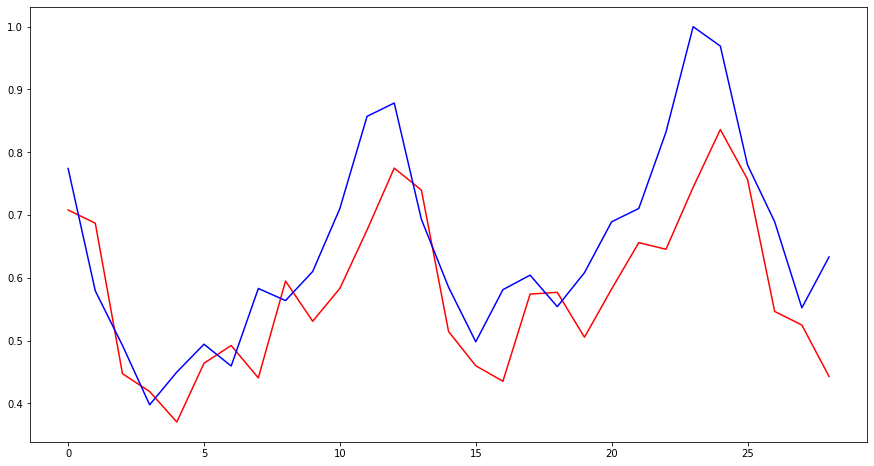

In [ ]:
# 12번 셀

# RNN으로 예측
pred = model.predict(X_test)

# print(pred.shape) # 예측값 확인
# 왜 출력데이터가 [0,1] 사이다? 답 : sigmoid 활성화 (중요하다)
# 입력데이터가 [0,1] 사이인 이유는 minmax. 
# LSTM 가중치들은 음수도 양수도 있다. 이 가중치들을 sigmoid가 [0,1]로 바꿔준다.

plt.figure(figsize=(15,8))
plt.plot(pred, 'r') # 예측값
plt.plot(Y_test, 'b') # 정답
# 원본 데이터 plot에서 뒷부분을 확대해서 보고 있는 것이다.
# domain 안줘도 된다

# mape가 인간이 보기는 좋다. 
# mape는 제대로 예측을 못한다. plot을 하면 망한 것을 확일 할 수 있다.
# 손실함수도 잘 골라야한다. -> mape 말고 mae를 써라.

In [ ]:
# 13번 셀

# 데이터 역전환 : 정규화 된 데이터([0,1])를 원본으로 전환 -> 얼마나 틀렸는지 직접 확인하기 위함
print('역전환 전 :',pred.flatten())
pred = scaler.inverse_transform(pred)  # 예측값을 원본으로 돌리기
print('역전환 후 :',pred.flatten())   # 소수점이 없다가 생겼다. , 46만 6천명

# 첫번째 평가용 문제 비교

print('RNN 예측값 : ',pred[0])
# print('RNN 정답 : ', Y_test[0]) # 스케일링 되어있다.

tmp = scaler.inverse_transform(Y_test)
print('RNN 정답 : ', tmp[0]) # 513, 505 -> 정확하지는 않지만 대략 맞는다..

역전환 전 : [0.7080359  0.68694985 0.44726458 0.41881415 0.37024125 0.46383047
 0.49209133 0.44056204 0.5948009  0.53078824 0.5831229  0.6761162
 0.77474433 0.7396903  0.51442456 0.4599193  0.4352086  0.57402843
 0.5767906  0.50532    0.58219403 0.65598357 0.64545804 0.74421287
 0.83613527 0.75688976 0.546377   0.52475464 0.44282672]
역전환 후 : [470.7626  459.84003 335.68304 320.94574 295.78497 344.2642  358.90332
 332.21112 412.10687 378.94833 406.05768 454.2282  505.31757 487.15958
 370.47192 342.2382  329.43805 401.34674 402.77753 365.75577 405.5765
 443.7995  438.3473  489.5023  537.11804 496.0689  387.02332 375.8229
 333.38425]
RNN 예측값 :  [470.7626]
RNN 정답 :  [505.]


요점정리


1.   시계열 데이터 : shuffle=False
2.   RNN 입력 스케일링 : MinMaxScaler()
3.   RNN 출력 스케일링 : activation='sigmoid
4.   반복학습 진행도 표시여부 : model.fit(verbose=0) : 끄기; model.fit(verbose=1) : 켜기
5. mape와 mae 비교 : mae 써라
6. 역전환 : scaler.Inverse_transform(pred)





In [ ]:
# mae와 mape 예측값이 다른 이유 : 가중치가 달라지면 예측값도 달라진다.